In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import dill
import numpy as np
import pandas as pd
import scipy.io as io
import datetime
import h5py
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sys.path.append('../../efish-physics-model/helper_functions')
sys.path.append('../../efish-physics-model/objects')
sys.path.append('../../efish-physics-model/uniform_points_generation')

In [3]:
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from assertion_tests import run_tests
run_tests()

'Success!'

# Scale the base to exaperimental measurements

In [4]:
def provide_data_like_base(
    receptor_x_positions,
    polyfit_id_ends=[28, 59],
    chin_value=0.125,
    adjustments=dict(ids=[23, 24, 25, 26, 27], vals=[0.2, 0.35, 0.25, 0.22, 0.2]),
):
    base_amplitude_data_like = np.polyfit(
        [-receptor_x_positions[polyfit_id_ends[0]] * 1e2, -receptor_x_positions[polyfit_id_ends[1]] * 1e2],
        [0.2, 0.5],
        1,
    )
    base_amplitude_data_like = np.array(
        [chin_value] * np.sum(receptor_x_positions >= 0)
        + list(
            base_amplitude_data_like[0] * (-receptor_x_positions[receptor_x_positions < 0] * 1e2)
            + base_amplitude_data_like[1]
        )
    )
    for i in range(len(adjustments["ids"])):
        base_amplitude_data_like[adjustments["ids"][i]] = adjustments["vals"][i]
    return base_amplitude_data_like

In [5]:
dataset_area = "head"
# dataset_area = "head_angled_chin"
dataset = dill.load(
    open(
        f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/dataset.pkl",
        # f"../../efish-physics-model/data/processed/data-2024_06_14-fish_with_angled_chin_for_detection-{dataset_area}/dataset.pkl",
        "rb",
    )
)
base_responses = dataset["electric_images"]["base"]["responses"][0].reshape(25 * 3, 16, 2)
receptors_locations = dataset["fish"]["dataframe"]["objs"].iloc[0].get_receptors_locations().reshape(25 * 3, 16, 3)

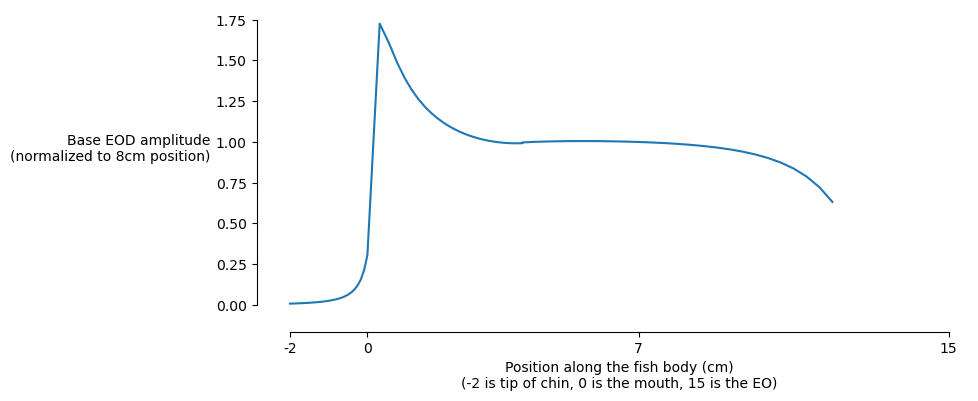

normalized at x position: 70 mm -> respective normalization value: 9434


In [6]:
normalized_id = 59
base_amplitude_avg = np.abs(base_responses[:, :, 0]).mean(1)
receptor_x_positions = receptors_locations[:, 0, 0]
plt.figure(figsize=(9, 4))
plt.plot(-receptor_x_positions * 1e2, base_amplitude_avg / base_amplitude_avg[normalized_id])
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks([-2, 0, round(-receptor_x_positions[normalized_id]*1e2), 15], [-2, 0, round(-receptor_x_positions[normalized_id]*1e2), 15])
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.show()
print(f"normalized at x position: {-receptor_x_positions[normalized_id]*1e3:.0f} mm -> respective normalization value: {base_amplitude_avg[normalized_id]:.0f}")

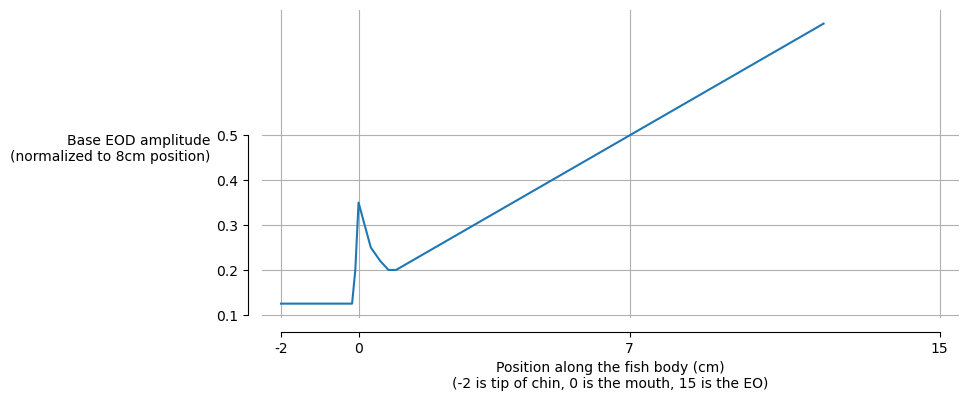

In [7]:
base_amplitude_data_like = provide_data_like_base(receptor_x_positions)
plt.figure(figsize=(9, 4))
plt.plot(-receptor_x_positions * 1e2, base_amplitude_data_like)
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks((np.arange(5) + 1) / 10)
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
# plt.yscale("log")
sns.despine(offset=10, trim=True)
plt.grid()
plt.show()

In [8]:
def scale_base_to_data_like(base_responses=base_responses, base_amplitude_data_like=base_amplitude_data_like, normalized_id=59):
    new_base_responses = (
        base_responses
        / base_responses[:, :, 0].mean(1)[:, np.newaxis, np.newaxis]
        * base_amplitude_data_like[:, np.newaxis, np.newaxis]
    )
    new_base_responses = new_base_responses / new_base_responses[normalized_id] * base_responses[normalized_id]
    return new_base_responses

In [9]:
new_base_responses = scale_base_to_data_like()

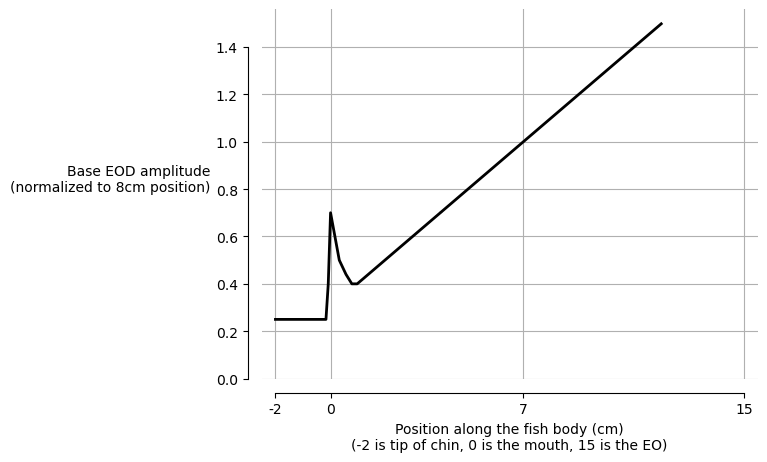

In [10]:
plt.plot(-receptor_x_positions*1e2, new_base_responses[:,:,0].mean(1) / new_base_responses[:,:,0].mean(1)[normalized_id], lw=2, c="k")
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks(np.arange(8) / 5)
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.grid()
# plt.savefig("leod-along-fish.svg")
plt.show()

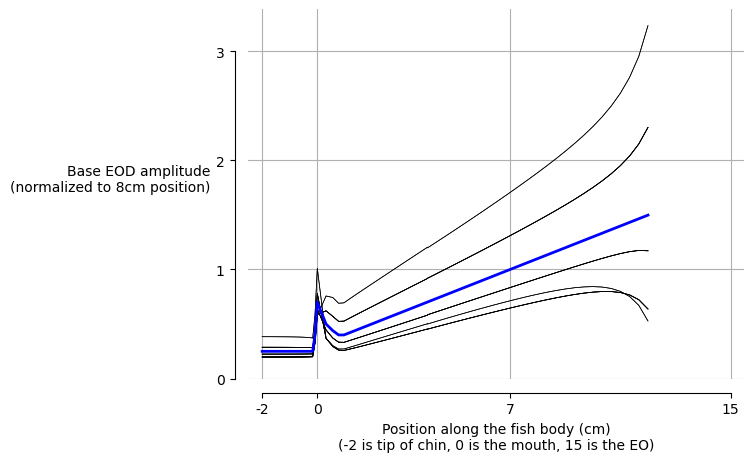

In [11]:
plt.plot(-receptor_x_positions*1e2, new_base_responses[:, :, 0] / new_base_responses[:,:,0].mean(1)[normalized_id], lw=0.5, c="k")
plt.plot(-receptor_x_positions*1e2, new_base_responses[:,:,0].mean(1) / new_base_responses[:,:,0].mean(1)[normalized_id], lw=2, c="b")
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks(np.arange(4))
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.grid()
plt.show()

# Detection with chin

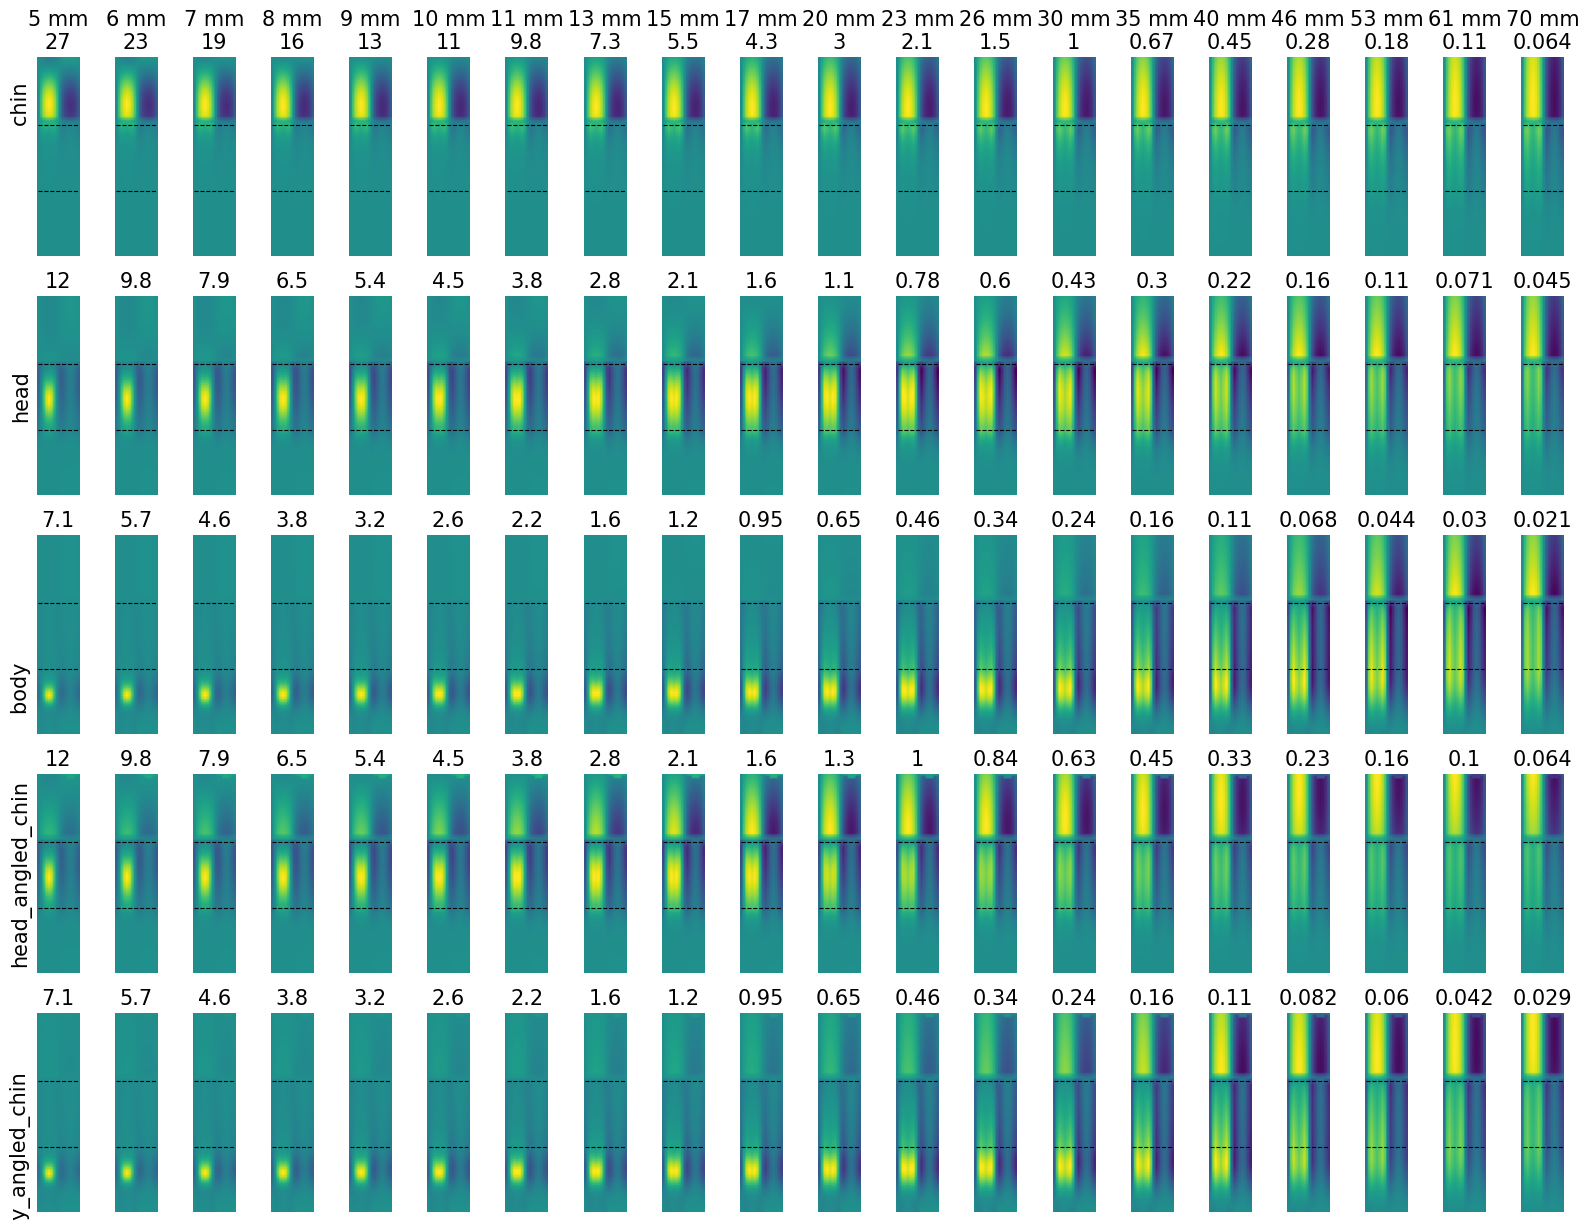

In [12]:
zone = "mz"
dataset_areas = ["chin", "head", "body", "head_angled_chin", "body_angled_chin"]
object_ids = np.arange(20)

zones = dict(mz=0, dlz=1)
f, axes = plt.subplots(len(dataset_areas), 20, figsize=(20, 3 * len(dataset_areas)))  # , gridspec_kw = {'wspace':0.09, 'hspace':-0.95})
for i, dataset_area in enumerate(dataset_areas):
    fpath = f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/"
    if "_" in dataset_area:
        fpath = f"../../efish-physics-model/data/processed/data-2024_06_14-fish_with_angled_chin_for_detection-{dataset_area}/"

    dataset = dill.load(
        open(
            f"{fpath}dataset.pkl",
            "rb",
        )
    )
    responses = h5py.File(
        f"{fpath}responses.hdf5",
        "r",
    )[
        "responses"
    ][:]
    base_response = dataset["electric_images"]["base"]["responses"][0]

    for j, object_id in enumerate(object_ids):
        selected_response = (
            (responses[object_id, :, zones[zone]] - base_response[:, zones[zone]]).reshape(25 * 3, 16)
            / new_base_responses[:, :, zones[zone]]
            * 100
        )
        vval = np.max(np.abs(selected_response))
        # selected_response = selected_response + np.random.randn(*selected_response.shape) * 1
        axes[i, j].imshow(selected_response, vmin=-vval, vmax=vval)
        sns.despine(left=True, bottom=True)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].plot([0, 15], [25, 25], "k--", lw=0.8)
        axes[i, j].plot([0, 15], [50, 50], "k--", lw=0.8)
        if j == 0:
            ylabel = dataset_area
            if dataset_area == "chin":
                ylabel = "                " + dataset_area
            if "body" in dataset_area:
                ylabel = dataset_area + "                "
            axes[i, j].set_ylabel(ylabel, fontsize=15)
        if i == 0:
            temp_distance = dataset["worms"]["position_ys"][object_id] * 1e3 - dataset["worms"]["radii"][0] * 1e3 - 1
            axes[i, j].set_title(f"{temp_distance:.0f} mm\n{vval:.2g}", fontsize=15)
        else:
            axes[i, j].set_title(f"{vval:.2g}", fontsize=15)
# plt.savefig("detection-with-chin.svg")
plt.show()

### Do 3D plot of EI

In [13]:
dataset_area = "head"
object_id = 12

fpath = f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/"

dataset = dill.load(open(f"{fpath}dataset.pkl", "rb"))
fish_obj = dataset["fish"]["dataframe"]["objs"].iloc[0]
responses = h5py.File(f"{fpath}responses.hdf5", "r")["responses"][:]
base_response = dataset["electric_images"]["base"]["responses"][0]

selected_response = (
    (responses[object_id, :, zones[zone]] - base_response[:, zones[zone]]).reshape(25 * 3, 16)
    / new_base_responses[:, :, zones[zone]]
    * 100
)

In [14]:
# fig = fish_obj.visualize_scatter(
#     intensity=selected_response.flatten(),
#     show_normals=0,
#     show_point_currents=7,
#     units_prefix="m",
#     xaxis_title="",
#     yaxis_title="",
#     zaxis_title="",
#     marker_alpha=1,
#     marker_size=20,
#     fig_width=2000,
#     fig_height=500,
# )

# EI Peak location on chin with location and distance

In [48]:
# dataset_version = ""
dataset_version = "v2-"
# dataset_version = "v3-"
dataset_folder = f"../../efish-physics-model/data/processed/data-2024_07_03-image_location_on_chin-{dataset_version}straight_chin/"
dataset = dill.load(
    open(
        f"{dataset_folder}dataset.pkl",
        "rb",
    )
)
receptor_x_positions = (
    dataset["fish"]["dataframe"]["objs"].iloc[0].get_receptors_locations().reshape(25 * 3, 16, 3)[:, 0, 0]
)
base_amplitude_data_like = provide_data_like_base(receptor_x_positions)
new_base_responses = scale_base_to_data_like(
    base_responses=dataset["electric_images"]["base"]["responses"][0].reshape(25 * 3, 16, 2),
    base_amplitude_data_like=base_amplitude_data_like,
    normalized_id=59,
)

## Peak location only

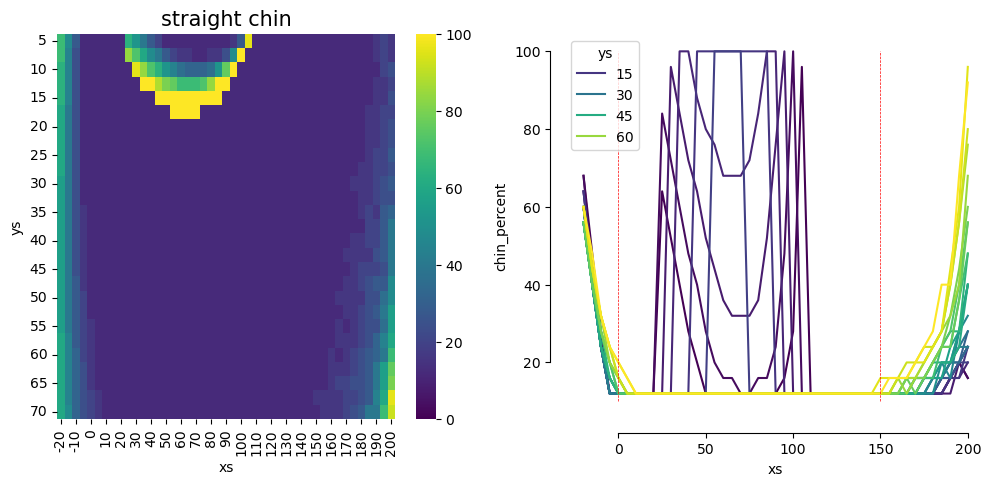

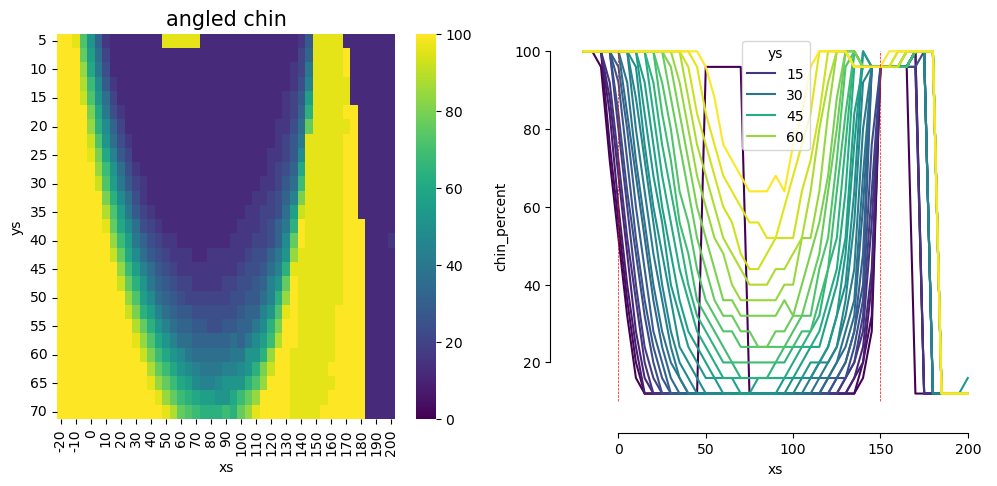

In [53]:
dataset_names = [
    f"data-2024_07_03-image_location_on_chin-{dataset_version}straight_chin",
    f"data-2024_07_03-image_location_on_chin-{dataset_version}angled_chin",
]
objects_ids = np.arange(dataset["worms"]["dataframe"].shape[0])
ei_locations_on_chin = {}
for i, dataset_name in enumerate(dataset_names):
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    title = dataset_name.split("-")[-1].replace("_", " ")
    dict_key = title.split(" ")[0]
    dataset_folder = f"../../efish-physics-model/data/processed/{dataset_name}/"
    zones = dict(mz=0, dlz=1)
    zone = "mz"

    dataset = dill.load(
        open(
            f"{dataset_folder}dataset.pkl",
            "rb",
        )
    )
    responses = h5py.File(
        f"{dataset_folder}responses.hdf5",
        "r",
    )[
        "responses"
    ][:]
    base_response = dataset["electric_images"]["base"]["responses"][0]
    ei_locations_on_chin[dict_key] = dataset["worms"]["dataframe"][["position_xs", "position_ys"]].copy()
    for k in ei_locations_on_chin[dict_key].columns:
        ei_locations_on_chin[dict_key][k.split("_")[-1]] = ei_locations_on_chin[dict_key][k].apply(
            lambda x: dataset["worms"][k][x]
        )
    ei_locations_on_chin[dict_key]["xs"] = -(ei_locations_on_chin[dict_key]["xs"] * 1e3).astype(int)
    ei_locations_on_chin[dict_key]["ys"] = np.round(
        (
            ei_locations_on_chin[dict_key]["ys"]
            - dataset["worms"]["radii"][0]
            - dataset["fish"]["dataframe"]["objs"].iloc[0].get_lateral_semi_axis()
        )
        * 1e3,
        1,
    ).astype(int)

    for j, object_id in enumerate(objects_ids):
        selected_response = (
            (responses[object_id, :, zones[zone]] - base_response[:, zones[zone]]).reshape(25 * 3, 16)
            / new_base_responses[:, :, zones[zone]]
            * 100
        )
        chin_response = selected_response[:25]
        ei_locations_on_chin[dict_key].loc[j, "max_response"] = np.abs(chin_response).max()
        ei_locations_on_chin[dict_key].loc[j, "chin_percent"] = (
            1 - np.where(np.abs(chin_response) == np.abs(chin_response).max())[0][0] / chin_response.shape[0]
        ) * 100
    ax[0].set_title(title, fontsize=15)
    sns.heatmap(
        # data=ei_locations_on_chin[dict_key].pivot(index="ys", columns="xs", values="max_response"),
        data=ei_locations_on_chin[dict_key].pivot(index="ys", columns="xs", values="chin_percent"),
        cmap="viridis",
        ax=ax[0], vmin=0, vmax=100
    )
    
    ax[0].tick_params(axis='y', labelrotation=0)
    sns.lineplot(
        # data=ei_locations_on_chin[dict_key].pivot(index="ys", columns="xs", values="max_response"),
        data=ei_locations_on_chin[dict_key], x="xs", y="chin_percent", hue="ys", palette="viridis", ax=ax[1]
    )
    ax[1].plot([0,0],[10,100],'r--',lw=0.5)
    ax[1].plot([150,150],[10,100],'r--',lw=0.5)
    sns.despine(ax=ax[1], offset=10, trim=True)
    plt.show()

## EIs on chin as function of location and distance

In [19]:
# dataset_names = [
#     "data-2024_07_03-image_location_on_chin-straight_chin",
#     "data-2024_07_03-image_location_on_chin-angled_chin",
# ]
# zones = dict(mz=0, dlz=1)
# zone = "mz"
# for i, dataset_name in enumerate(dataset_names):
#     f, axes = plt.subplots(21, 21, sharex=True, sharey=True, figsize=(21, 30.5))
#     dataset_folder = f"../../efish-physics-model/data/processed/{dataset_name}/"
#     dataset = dill.load(
#         open(
#             f"{dataset_folder}dataset.pkl",
#             "rb",
#         )
#     )
#     responses = h5py.File(
#         f"{dataset_folder}responses.hdf5",
#         "r",
#     )[
#         "responses"
#     ][:]
#     base_response = dataset["electric_images"]["base"]["responses"][0]
#     ei_locations_on_chin = dataset["worms"]["dataframe"][["position_xs", "position_ys"]].copy()
#     for k in ei_locations_on_chin.columns:
#         ei_locations_on_chin[k.split("_")[-1]] = ei_locations_on_chin[k].apply(
#             lambda x: dataset["worms"][k][x]
#         )
#     ei_locations_on_chin["xs"] = (ei_locations_on_chin["xs"] * 1e3).astype(int)
#     ei_locations_on_chin["ys"] = np.round(
#         (
#             ei_locations_on_chin["ys"]
#             - dataset["worms"]["radii"][0]
#             - dataset["fish"]["dataframe"]["objs"].iloc[0].get_lateral_semi_axis()
#         )
#         * 1e3,
#         1,
#     ).astype(int)

#     for j, row in ei_locations_on_chin.iterrows():
#         xid = row["position_xs"]
#         yid = row["position_ys"]
#         object_id = row.name
#         selected_response = (
#             (responses[object_id, :, zones[zone]] - base_response[:, zones[zone]]).reshape(25 * 3, 16)
#             / new_base_responses[:, :, zones[zone]]
#             * 100
#         )
#         chin_response = selected_response[:25]
        
#         vval = np.max(np.abs(chin_response))
#         axes[yid, xid].imshow(chin_response, vmin=-vval, vmax=vval)
#         sns.despine(left=True, bottom=True)
#         axes[yid, xid].set_xticks([])
#         axes[yid, xid].set_yticks([])
#         if yid == 20:
#             axes[yid, xid].set_xlabel(int(-row["xs"]))
#         if xid == 0:
#             axes[yid, xid].set_ylabel(int(row["ys"]))
#     plt.show()